In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, FragmentCatalog, FunctionalGroups, MolFromSmiles, FilterCatalog
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean
import mol2graph
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from sklearn.manifold import TSNE

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
plt.style.use("ggplot")

In [3]:
train_mols = [m for m in Chem.SDMolSupplier('solubility.train.sdf') ]
test_mols = [m for m in Chem.SDMolSupplier('solubility.test.sdf')]
#test_mols = [m for m in Chem.SDMolSupplier('solubility.test.sdf') if m.GetProp('SOL_classification') == "(A) low"]
sol_cls_dict = {'(A) low':0, '(B) medium':1, '(C) high':2}
print(len(train_mols), len(test_mols))
print(test_mols[50].GetPropsAsDict())  #Returns a dictionary of the properties set on the Atom

1025 257
{'ID': 256, 'NAME': '2,3,4,5,6-PCB', 'SOL': -7.92, 'SMILES': 'Clc1c(Cl)c(Cl)c(Cl)c(Cl)c1c2ccccc2', 'SOL_classification': '(A) low'}


In [4]:
functionalGroups = FilterCatalog.GetFunctionalGroupHierarchy()
[match.filterMatch.GetName() for match in functionalGroups.GetFilterMatches(MolFromSmiles('Clc1c(Cl)c(Cl)c(Cl)c(Cl)c1c2ccccc2'))]

['Halogen.Aromatic', 'Halogen.NotFluorine.Aromatic']

{'ID': 5, 'NAME': '3-methylpentane', 'SOL': -3.68, 'SMILES': 'CCC(C)CC', 'SOL_classification': '(A) low'}
{'ID': 10, 'NAME': '2,4-dimethylpentane', 'SOL': -4.26, 'SMILES': 'CC(C)CC(C)C', 'SOL_classification': '(A) low'}
{'ID': 15, 'NAME': '1-pentene', 'SOL': -2.68, 'SMILES': 'CCCC=C', 'SOL_classification': '(B) medium'}
{'ID': 20, 'NAME': 'cyclohexene', 'SOL': -2.59, 'SMILES': 'C1CC=CCC1', 'SOL_classification': '(B) medium'}
{'ID': 25, 'NAME': '1,4-pentadiene', 'SOL': -2.09, 'SMILES': 'C=CCC=C', 'SOL_classification': '(B) medium'}


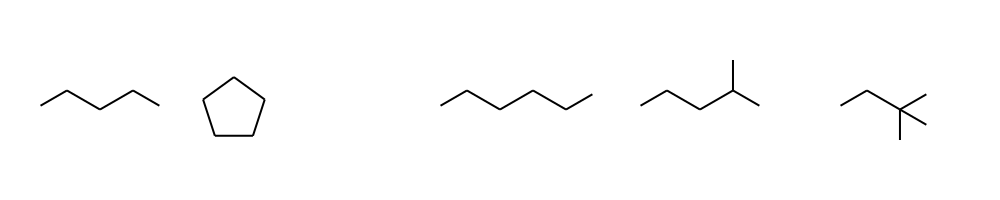

In [5]:
train_mols = [m for m in Chem.SDMolSupplier('solubility.train.sdf') ]
test_mols = [m for m in Chem.SDMolSupplier('solubility.test.sdf')]
for i in range(5):
    print(test_mols[i].GetPropsAsDict())
Draw.MolsToGridImage(train_mols[:5], molsPerRow=5)

In [6]:
# train_mols = [m for m in Chem.SDMolSupplier('solubility.train.sdf') if m.GetProp('SOL_classification') == "(A) low" ] + [m2 for m2 in Chem.SDMolSupplier('solubility.test.sdf') if m2.GetProp('SOL_classification') == "(A) low" ]
# test_mols = [m for m in Chem.SDMolSupplier('solubility.train.sdf') if m.GetProp('SOL_classification') == "(C) high" ] + [m2 for m2 in Chem.SDMolSupplier('solubility.test.sdf') if m2.GetProp('SOL_classification') == "(C) high" ]
# print(len(train_mols), len(test_mols))

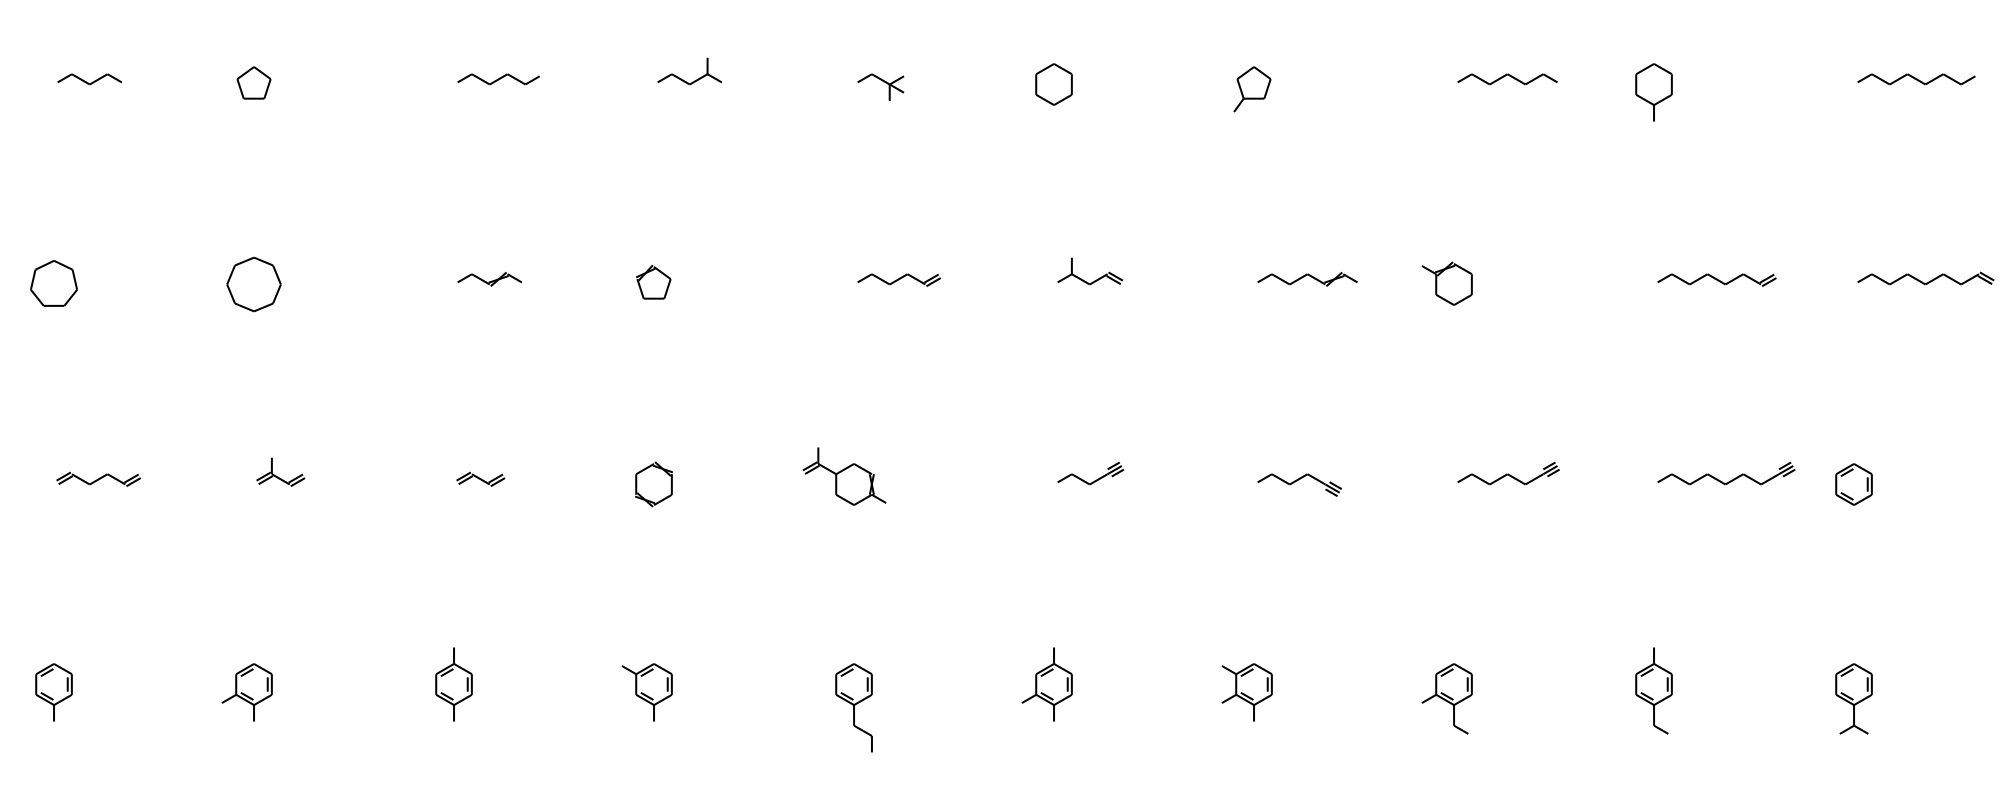

In [7]:
Draw.MolsToGridImage(train_mols[:40], molsPerRow=10)

In [8]:
train_X = [mol2graph.mol2vec(m) for m in train_mols]
for i, data in enumerate(train_X):
    y_label = sol_cls_dict[train_mols[i].GetProp('SOL_classification')]
    y = float(train_mols[i].GetProp('SOL')) 
    data.y = torch.tensor([y], dtype=torch.float)
    data.y_label = torch.tensor([y_label], dtype=torch.long)
    #data.adj = torch.tensor(Chem.rdmolops.GetAdjacencyMatrix(train_mols[i]), dtype = torch.float)

test_X = [mol2graph.mol2vec(m) for m in test_mols]
for i, data in enumerate(test_X):
    y_label = sol_cls_dict[test_mols[i].GetProp('SOL_classification')]
    y = float(test_mols[i].GetProp('SOL')) 
    data.y = torch.tensor([y], dtype=torch.float)
    data.y_label = torch.tensor([y_label], dtype=torch.long)
    #data.adj = torch.tensor(Chem.rdmolops.GetAdjacencyMatrix(test_mols[i]), dtype = torch.float)

In [9]:
# atom.GetSymbol(),
# atom.GetDegree(),
# atom.GetImplicitValence()
# atom.GetFormalCharge()
# atom.GetNumRadicalElectrons()
# atom.GetHybridization() #혼성궤도
# atom.GetIsAromatic() #방향족

In [10]:
train_X[0]

Data(edge_attr=[8, 6], edge_index=[2, 8], x=[5, 75], y=[1], y_label=[1])

In [11]:
train_loader = DataLoader(train_X, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=32, shuffle=False, drop_last=True)

In [12]:
for t in train_loader:
    print(t)
    break

Batch(batch=[329], edge_attr=[656, 6], edge_index=[2, 656], ptr=[33], x=[329, 75], y=[32], y_label=[32])


In [13]:
n_features = 75

In [14]:
class GCNModelVAE(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim1, hidden_dim2, dropout):
        super(GCNModelVAE, self).__init__()
        self.conv1 = GCNConv(input_feat_dim, hidden_dim1)
        self.conv2 = GCNConv( hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv( hidden_dim1, hidden_dim2)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.Linear(hidden_dim1, input_feat_dim),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim2, hidden_dim2),    
            nn.LeakyReLU(),    
            BatchNorm1d(hidden_dim2),
            nn.Linear(hidden_dim2, 16),
            nn.LeakyReLU(),
            BatchNorm1d(16),
            nn.Linear(16,1),
        )

    def encode(self, x, edge_index):
        hidden1 = F.relu(self.conv1(x, edge_index))
        return F.relu(self.conv2(hidden1, edge_index)), F.relu(self.conv3(hidden1, edge_index))

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, data):
        mu, logvar = self.encode(data.x, data.edge_index)
        z = self.reparameterize(mu, logvar)
        z_pool = global_mean_pool(z, data.batch)
        label = self.classifier(z_pool)
        #label = F.log_softmax(label, dim=1)
        out = self.decoder(z)
        return  out,mu, logvar, label, z_pool

In [59]:
def loss_func(recon_x, x, mu, log_var, pos_weight,label_pred, label_true):
    recon_loss = F.binary_cross_entropy_with_logits(recon_x, x, pos_weight = pos_weight) 
    #KLD_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    #clf_loss = F.nll_loss(label_pred, label_true) 
    clf_loss = F.mse_loss(label_pred.squeeze(), label_true, reduction = "sum") 
    #print(recon_loss, clf_loss)
    return  recon_loss + clf_loss 

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModelVAE(n_features, 128, 64, 0.1).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [61]:
print(model)

GCNModelVAE(
  (conv1): GCNConv(75, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(128, 64)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=75, bias=True)
    (2): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [62]:
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output,mu,logvar,label,z = model(data)
        pos_weight = float(data.x.shape[0] * data.x.shape[1] - data.x.sum()) / data.x.sum()
        #print(pos_weight)
        loss = loss_func(output, data.x,mu, logvar, pos_weight, label, data.y )
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_X)

In [63]:
def test(loader):
    with torch.no_grad():
        model.eval()
        loss_all = 0
        outputs = []
        for data in loader:
            data = data.to(device)
            output,mu, logvar,label,z = model(data)
            for out in output:
                outputs.append(out.cpu().numpy())
            pos_weight = float(data.x.shape[0] * data.x.shape[1] - data.x.sum()) / data.x.sum()
            #print(pos_weight)
            loss = loss_func(output, data.x,mu, logvar, pos_weight, label, data.y )
            loss_all += loss.item() * data.num_graphs
        return loss_all / len(loader.dataset)

In [64]:
def test_clf(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        output,mu, logvar,label,z = model(data)
        pred = label.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [65]:
hist = {"loss":[], "acc":[], "test_loss":[]}
epochs = 300
for epoch in range(epochs):
    train_loss = train(epoch)
    test_loss = test(test_loader)
    #test_acc = test_clf(test_loader)
    hist["loss"].append(train_loss)
    hist["test_loss"].append(test_loss)
    #hist["acc"].append(test_acc)
    if (epoch+1) %10 == 0:
        print(f'Epoch: {epoch+1}, Train loss: {train_loss:.3}, Test loss: {test_loss:.3}')

Epoch: 10, Train loss: 40.2, Test loss: 32.7
Epoch: 20, Train loss: 36.4, Test loss: 29.3
Epoch: 30, Train loss: 32.5, Test loss: 31.2
Epoch: 40, Train loss: 32.4, Test loss: 26.9
Epoch: 50, Train loss: 30.6, Test loss: 23.7
Epoch: 60, Train loss: 27.1, Test loss: 23.2
Epoch: 70, Train loss: 26.9, Test loss: 36.3
Epoch: 80, Train loss: 24.5, Test loss: 20.5
Epoch: 90, Train loss: 25.5, Test loss: 21.7
Epoch: 100, Train loss: 22.1, Test loss: 20.9
Epoch: 110, Train loss: 19.7, Test loss: 20.0
Epoch: 120, Train loss: 19.2, Test loss: 21.7
Epoch: 130, Train loss: 17.8, Test loss: 20.1
Epoch: 140, Train loss: 18.0, Test loss: 18.8
Epoch: 150, Train loss: 19.6, Test loss: 27.2
Epoch: 160, Train loss: 22.2, Test loss: 28.0
Epoch: 170, Train loss: 16.7, Test loss: 22.2
Epoch: 180, Train loss: 18.6, Test loss: 20.9
Epoch: 190, Train loss: 17.7, Test loss: 17.6
Epoch: 200, Train loss: 16.0, Test loss: 19.0
Epoch: 210, Train loss: 16.1, Test loss: 17.8
Epoch: 220, Train loss: 15.0, Test loss: 18

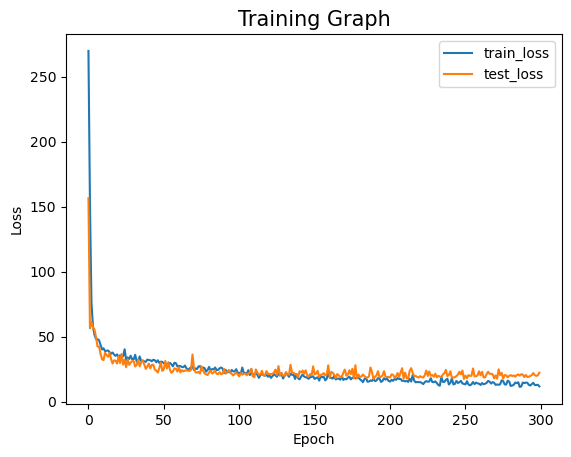

In [66]:
plt.style.use("default")
plt.plot([e for e in range(epochs)], hist["loss"], label="train_loss")
#ax.plot([e for e in range(epochs], hist["acc"], label="train_acc")
plt.plot([e for e in range(epochs)], hist["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Graph", fontsize = 15)
plt.legend()
plt.show()

In [70]:
def get_test_output(loader):
    model.eval()
    loss_all = 0.0
    clf_all = 0.0
    correct = 0
    z_list = []
    recon_list = []
    pred_list = []
    target_list = []
    for data in loader:
        data = data.to(device)
        recon,_,_,pred,z = model(data)
        
        z_list = z_list + z.cpu().tolist()
        recon_list = recon_list + recon.cpu().tolist()
        pred_list = pred_list + pred.squeeze().cpu().tolist()
        target_list = target_list + data.y.cpu().tolist()
        
        clf_loss = F.mse_loss(pred.squeeze(),data.y, reduction="sum")
        pos_weight = float(data.x.shape[0] * data.x.shape[1] - data.x.sum()) / data.x.sum()
        recon_loss = F.binary_cross_entropy_with_logits(recon, data.x, pos_weight = pos_weight)
        
        clf_all += clf_loss.item() * data.num_graphs
        loss_all += recon_loss.item() * data.num_graphs
        #correct += pred.eq(data.y).sum().item()
    print("Recon loss: {}, Clf loss: {}".format(loss_all / len(loader.dataset), clf_all / len(loader.dataset)))
    return np.array(z_list), np.array(recon_list), np.array(pred_list), np.array(target_list)

In [71]:
def np_mse(x, y):
    return np.mean(np.square(x-y))

In [72]:
z, recon, pred, target = get_test_output(train_loader)

Recon loss: 0.9543573091088272, Clf loss: 7.930114478134527


In [73]:
z2, recon2, pred2, target2 = get_test_output(test_loader)

Recon loss: 0.9512262307252402, Clf loss: 21.405340884910018


In [ ]:
pred2[:100]

In [ ]:
z2[7]

In [ ]:
z2[10]

In [ ]:
np_mse(z2[7], z2[10])

In [ ]:
np_mse(z2[11], z2[10])

In [ ]:
target2[:100]

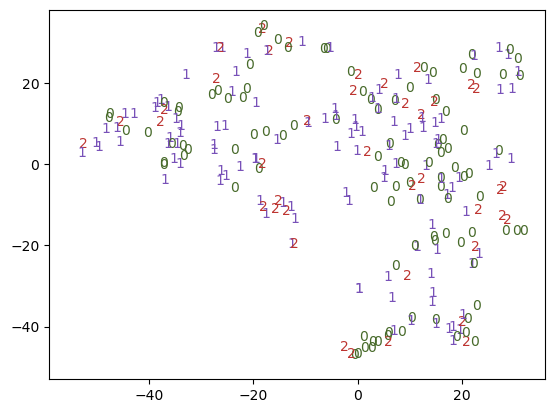

In [55]:
colors = ['#476A2A', '#7851B8', '#BD3430', '#4A2D4E', '#875525','#A83683', '#4E655E', '#853541', '#3A3120', '#535D8E']
z_tsne = TSNE(n_components=2).fit_transform(z)
for i in range(len(z2)):
    plt.text(z_tsne[i,0], z_tsne[i,1], str(test_loader.dataset[i].y_label.item()), color = colors[test_loader.dataset[i].y_label])
#plt.legend()
plt.xlim(z_tsne[:, 0].min()-5, z_tsne[:, 0].max()+5) # 최소, 최대
plt.ylim(z_tsne[:, 1].min()-5, z_tsne[:, 1].max()+5) # 최소, 최대
plt.show()

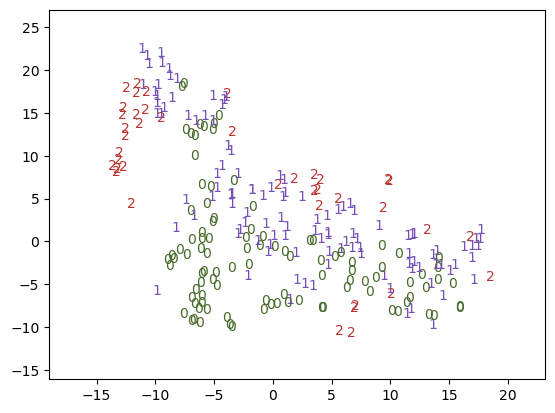

In [75]:
colors = ['#476A2A', '#7851B8', '#BD3430', '#4A2D4E', '#875525','#A83683', '#4E655E', '#853541', '#3A3120', '#535D8E']
z_tsne = TSNE(n_components=2).fit_transform(z2)
for i in range(len(z2)):
    plt.text(z_tsne[i,0], z_tsne[i,1], str(test_loader.dataset[i].y_label.item()), color = colors[test_loader.dataset[i].y_label])
#plt.legend()
plt.xlim(z_tsne[:, 0].min()-5, z_tsne[:, 0].max()+5) # 최소, 최대
plt.ylim(z_tsne[:, 1].min()-5, z_tsne[:, 1].max()+5) # 최소, 최대
plt.show()

tensor([-5.2000])


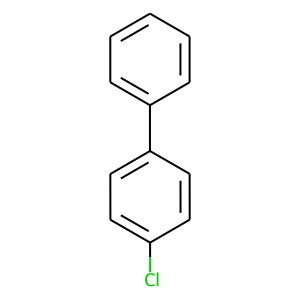

In [76]:
idx = 43
print(test_X[idx].y)
Draw.MolToImage(test_mols[idx])

13 -4.170000076293945
55 -4.400000095367432
181 -7.110000133514404
44 -5.28000020980835
14 -4.289999961853027
186 -1.7699999809265137
23 -2.309999942779541
162 0.3199999928474426
144 -0.4000000059604645
127 -2.359999895095825


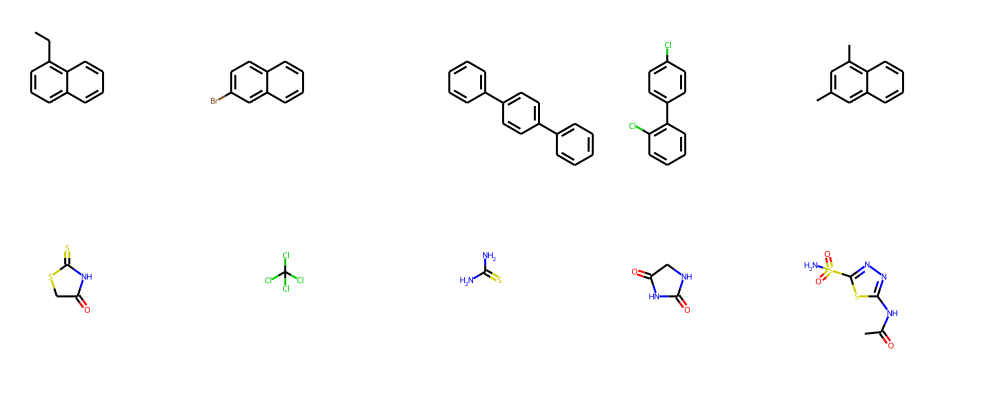

In [77]:
mse = []
for elem in z2:
    mse.append(np.mean(np.square(elem-z2[idx])))
low = great = []
for i in range(1,6):
    l = mse.index(sorted(mse)[i])
    low.append(l)
    print(l, test_X[l].y.item())
for j in range(5):
    g = mse.index(sorted(mse, reverse=True)[j])
    great.append(g)
    print(g, test_X[g].y.item())
Draw.MolsToGridImage(np.array(test_mols)[low], molsPerRow=5)
Draw.MolsToGridImage(np.array(test_mols)[great], molsPerRow=5)

In [ ]:
.